# GradCAM Heatmap Experimentation Notebook

This notebook provides tools to visualize and experiment with Grad-CAM (Gradient-weighted Class Activation Mapping) heatmaps for the ROP Detection model.

## Features:
- Load and visualize GradCAM heatmaps for individual images
- Compare different target layers for GradCAM
- Batch processing of multiple images
- Interactive visualization with adjustable overlay parameters
- Side-by-side comparison of original vs. heatmap overlay

## 1. Setup and Imports

In [1]:
import torch
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import sys

# Add project root to path
PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.models.resnet import ResNet18ROP
from src.data.transforms import get_transforms

# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"Project root: {PROJECT_ROOT}")

Using device: cpu
Project root: c:\Users\HP\Desktop\ROPDetectionAIML


## 2. GradCAM Implementation

In [3]:
class GradCAM:
    """
    Grad-CAM implementation for visualizing CNN attention.
    
    Args:
        model: The neural network model
        target_layer: The layer to compute GradCAM on (typically last conv layer)
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(_, __, output):
            self.activations = output.detach()

        def backward_hook(_, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        """
        Generate GradCAM heatmap.
        
        Args:
            input_tensor: Input image tensor (B, C, H, W)
            target_class: Class index to compute gradients for (default: predicted class)
        
        Returns:
            cam: GradCAM heatmap (B, H, W)
        """
        self.model.eval()

        logits = self.model(input_tensor)
        
        if target_class is None:
            score = logits[:, 0]  # Binary classification
        else:
            score = logits[:, target_class]

        self.model.zero_grad()
        score.backward(retain_graph=True)

        # Global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        
        # Weighted combination of activation maps
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)  # ReLU to keep only positive contributions

        # Normalize
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam

## 3. Visualization Utilities

In [4]:
def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlay heatmap on original image.
    
    Args:
        image: Original image (H, W, 3) in RGB
        heatmap: GradCAM heatmap (H, W)
        alpha: Blend factor (0 = only image, 1 = only heatmap)
        colormap: OpenCV colormap to use
    
    Returns:
        overlay: Blended image (H, W, 3) in RGB
    """
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    return cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)


def visualize_gradcam(original_img, heatmap, prediction, label, alpha=0.4, figsize=(15, 5)):
    """
    Visualize original image, heatmap, and overlay side by side.
    
    Args:
        original_img: Original image (H, W, 3) in RGB
        heatmap: GradCAM heatmap (H, W)
        prediction: Model prediction probability
        label: Ground truth label
        alpha: Overlay blend factor
        figsize: Figure size
    """
    overlay = overlay_heatmap(original_img, heatmap, alpha)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Original image
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Heatmap only
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    im = axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Overlay
    axes[2].imshow(overlay)
    pred_label = "ROP+" if prediction > 0.5 else "ROP-"
    gt_label = "ROP+" if label == 1 else "ROP-"
    correct = "✓" if (prediction > 0.5) == (label == 1) else "✗"
    axes[2].set_title(f'Overlay\nPred: {pred_label} ({prediction:.3f}) | GT: {gt_label} {correct}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


def visualize_multiple_alphas(original_img, heatmap, alphas=[0.2, 0.4, 0.6, 0.8]):
    """
    Visualize overlay with different alpha values.
    """
    fig, axes = plt.subplots(1, len(alphas) + 1, figsize=(4 * (len(alphas) + 1), 4))
    
    axes[0].imshow(original_img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    for i, alpha in enumerate(alphas):
        overlay = overlay_heatmap(original_img, heatmap, alpha)
        axes[i + 1].imshow(overlay)
        axes[i + 1].set_title(f'Alpha = {alpha}')
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

## 4. Load Model and Data

In [5]:
# Configuration
CHECKPOINT_PATH = PROJECT_ROOT / "checkpoints" / "best_model.pth"
VAL_CSV_PATH = PROJECT_ROOT / "data" / "splits" / "val.csv"
TEST_CSV_PATH = PROJECT_ROOT / "data" / "splits" / "test.csv"

# Load model
model = ResNet18ROP(pretrained=False).to(DEVICE)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.eval()
print(f"Model loaded from: {CHECKPOINT_PATH}")

# Get transforms
transform = get_transforms(train=False)

# Load validation data
val_df = pd.read_csv(VAL_CSV_PATH)
print(f"\nValidation set: {len(val_df)} images")
print(f"Label distribution:\n{val_df['ROP Label'].value_counts()}")

c:\Users\HP\Desktop\ROPDetectionAIML\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\Desktop\ROPDetectionAIML\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded from: c:\Users\HP\Desktop\ROPDetectionAIML\checkpoints\best_model.pth

Validation set: 86 images
Label distribution:
ROP Label
0    63
1    23
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_12536\2352806535.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=

## 5. Initialize GradCAM with Different Layers

In [6]:
# Available layers in ResNet18 for GradCAM
print("Available layers for GradCAM:")
print("- model.backbone.layer1 (early features)")
print("- model.backbone.layer2 (mid-level features)")
print("- model.backbone.layer3 (high-level features)")
print("- model.backbone.layer4 (final conv layer - recommended)")

# Initialize GradCAM with the final layer (most commonly used)
gradcam_layer4 = GradCAM(model, model.backbone.layer4)
print("\n✓ GradCAM initialized with layer4")

Available layers for GradCAM:
- model.backbone.layer1 (early features)
- model.backbone.layer2 (mid-level features)
- model.backbone.layer3 (high-level features)
- model.backbone.layer4 (final conv layer - recommended)

✓ GradCAM initialized with layer4


## 6. Helper Function to Process Single Image

In [7]:
def process_image(img_path, transform, model, gradcam, device=DEVICE):
    """
    Process a single image and generate GradCAM.
    
    Args:
        img_path: Path to the image
        transform: Image transforms
        model: The model
        gradcam: GradCAM instance
        device: Device to use
    
    Returns:
        original_img: Original image as numpy array (RGB)
        heatmap: GradCAM heatmap
        prediction: Model prediction probability
    """
    # Load original image for visualization
    orig_img = cv2.imread(str(img_path))
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # Prepare input tensor
    pil_img = Image.open(img_path).convert("RGB")
    input_tensor = transform(pil_img).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        logits = model(input_tensor)
        prediction = torch.sigmoid(logits).item()
    
    # Generate GradCAM (need gradients, so no torch.no_grad)
    cam = gradcam.generate(input_tensor)
    heatmap = cam[0].cpu().numpy()
    
    return orig_img, heatmap, prediction

## 7. Experiment: Single Image GradCAM

In [8]:
# Select a sample image from validation set
# Try with ROP positive cases first (label = 1)
rop_positive = val_df[val_df['ROP Label'] == 1]
rop_negative = val_df[val_df['ROP Label'] == 0]

print(f"ROP+ samples: {len(rop_positive)}")
print(f"ROP- samples: {len(rop_negative)}")

# Select first ROP+ image
if len(rop_positive) > 0:
    sample_row = rop_positive.iloc[0]
    img_path = sample_row['Source']
    label = sample_row['ROP Label']
    
    print(f"\nSelected image: {img_path}")
    print(f"Ground truth label: {'ROP+' if label == 1 else 'ROP-'}")

ROP+ samples: 23
ROP- samples: 63

Selected image: C:\Users\HP\Desktop\ROPDetectionAIML\data\images\2-4_25Nov\set 2\Input\6076V1\8.jpg
Ground truth label: ROP+


Model prediction: 0.9852 (ROP+)


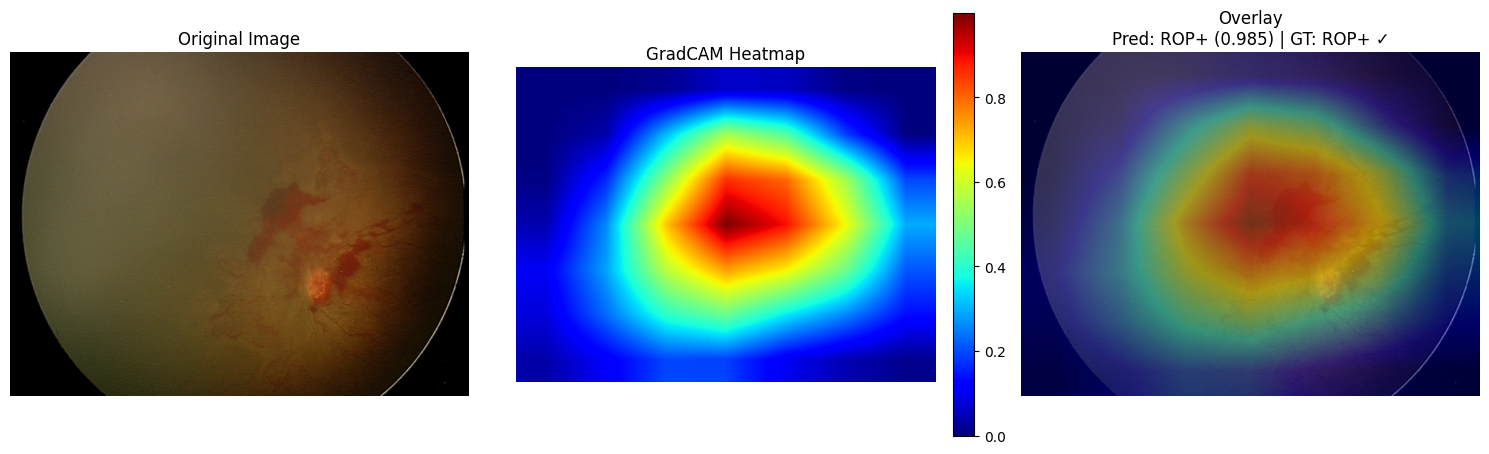

In [9]:
# Generate and visualize GradCAM for the selected image
orig_img, heatmap, prediction = process_image(img_path, transform, model, gradcam_layer4)

print(f"Model prediction: {prediction:.4f} ({'ROP+' if prediction > 0.5 else 'ROP-'})")
visualize_gradcam(orig_img, heatmap, prediction, label, alpha=0.4)

## 8. Experiment: Compare Different Alpha Values

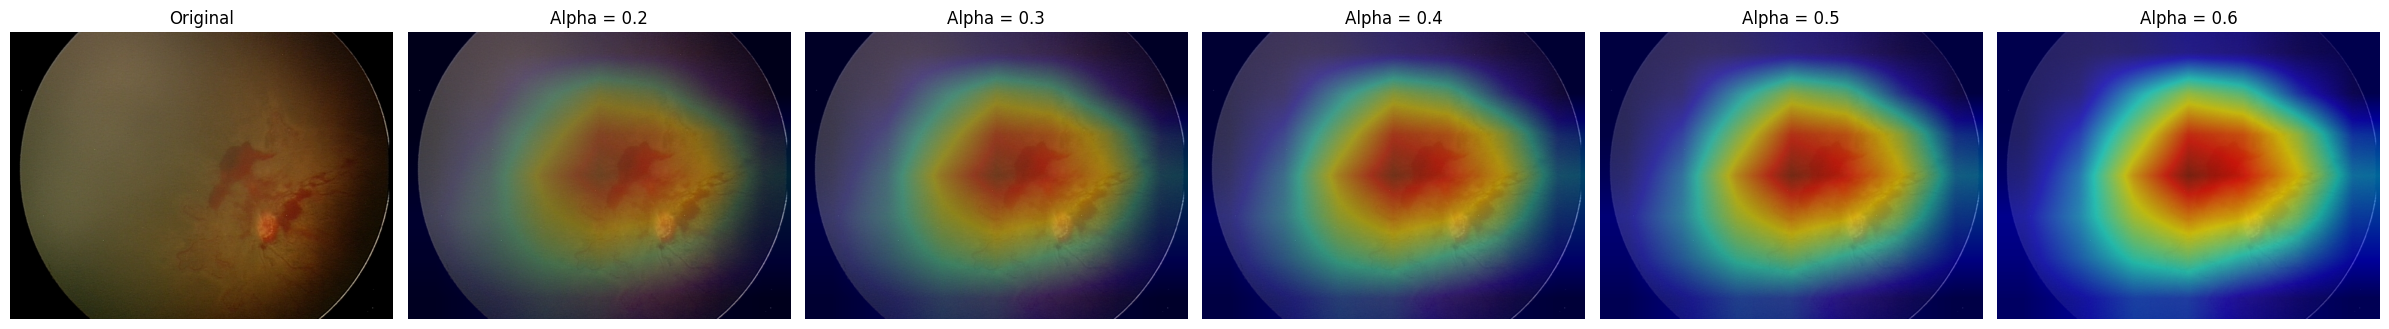

In [10]:
# Visualize the same image with different alpha values
visualize_multiple_alphas(orig_img, heatmap, alphas=[0.2, 0.3, 0.4, 0.5, 0.6])

## 9. Experiment: Compare Different Layers

c:\Users\HP\Desktop\ROPDetectionAIML\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\Desktop\ROPDetectionAIML\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\HP\AppData\Local\Temp\ipykernel_12536\1983653741.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value

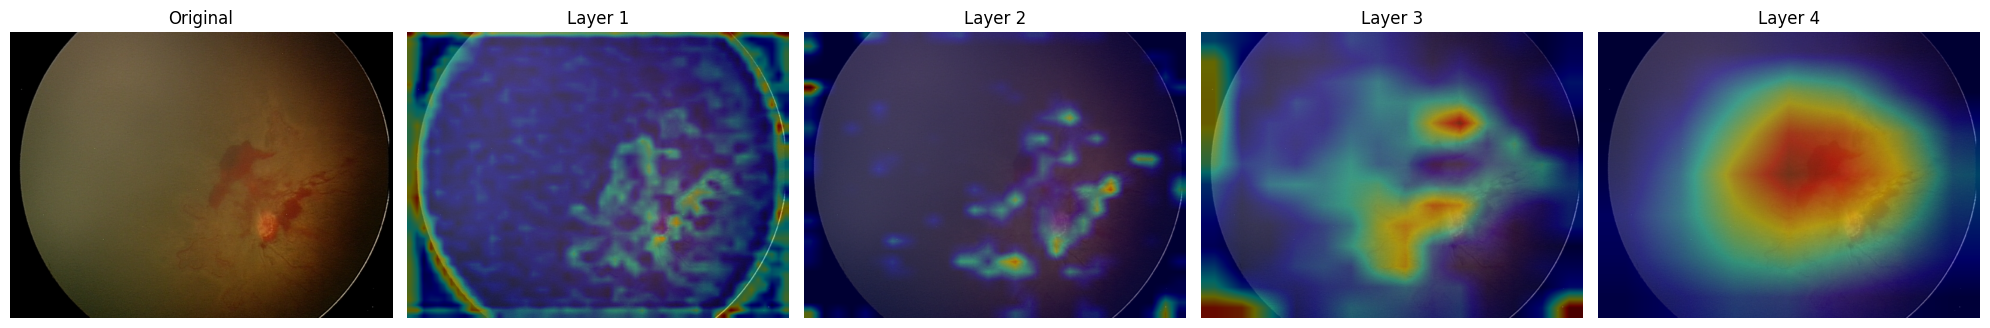

In [11]:
# Create GradCAM instances for different layers
# Note: Need to reload model to avoid hook conflicts
def compare_layers(img_path, transform, device=DEVICE):
    """
    Compare GradCAM outputs from different ResNet layers.
    """
    layers_config = [
        ('Layer 1', 'layer1'),
        ('Layer 2', 'layer2'),
        ('Layer 3', 'layer3'),
        ('Layer 4', 'layer4'),
    ]
    
    # Load original image
    orig_img = cv2.imread(str(img_path))
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # Prepare input
    pil_img = Image.open(img_path).convert("RGB")
    input_tensor = transform(pil_img).unsqueeze(0).to(device)
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Original image
    axes[0].imshow(orig_img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    for i, (name, layer_name) in enumerate(layers_config):
        # Load fresh model for each layer
        temp_model = ResNet18ROP(pretrained=False).to(device)
        temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
        temp_model.eval()
        
        # Get target layer
        target_layer = getattr(temp_model.backbone, layer_name)
        
        # Create GradCAM
        gradcam = GradCAM(temp_model, target_layer)
        cam = gradcam.generate(input_tensor.clone())
        heatmap = cam[0].cpu().numpy()
        
        # Create overlay
        overlay = overlay_heatmap(orig_img, heatmap, alpha=0.4)
        
        axes[i + 1].imshow(overlay)
        axes[i + 1].set_title(name)
        axes[i + 1].axis('off')
        
        del temp_model, gradcam
    
    plt.tight_layout()
    plt.show()

# Compare layers
compare_layers(img_path, transform)

## 10. Experiment: Batch Processing Multiple Images

In [11]:
def batch_visualize_gradcam(df, n_samples=5, alpha=0.4):
    """
    Visualize GradCAM for multiple images.
    
    Args:
        df: DataFrame with 'Source' and 'ROP Label' columns
        n_samples: Number of samples to visualize
        alpha: Overlay alpha value
    """
    # Reload model to avoid hook accumulation
    temp_model = ResNet18ROP(pretrained=False).to(DEVICE)
    temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
    temp_model.eval()
    
    gradcam = GradCAM(temp_model, temp_model.backbone.layer4)
    
    sample_df = df.sample(n=min(n_samples, len(df)), random_state=42)
    
    for idx, row in sample_df.iterrows():
        img_path = row['Source']
        label = row['ROP Label']
        
        try:
            orig_img, heatmap, prediction = process_image(
                img_path, transform, temp_model, gradcam
            )
            
            print(f"\n{'='*60}")
            print(f"Image: {Path(img_path).name}")
            visualize_gradcam(orig_img, heatmap, prediction, label, alpha)
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    del temp_model, gradcam

GradCAM for ROP POSITIVE cases


C:\Users\HP\AppData\Local\Temp\ipykernel_13220\2946742073.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_loc


Image: 12.jpg


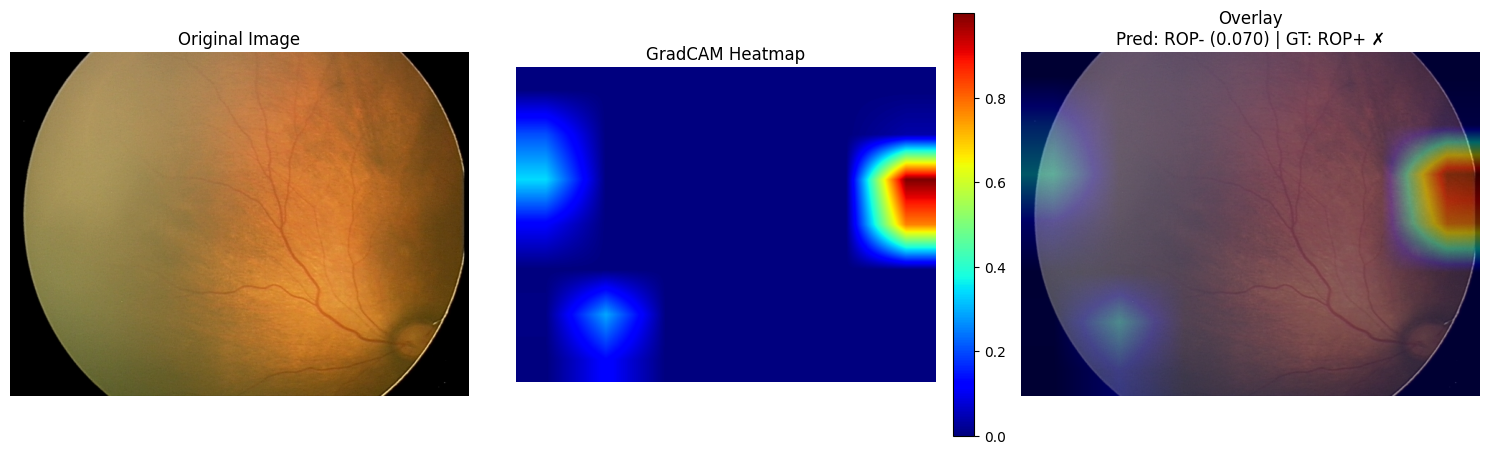


Image: 6.jpg


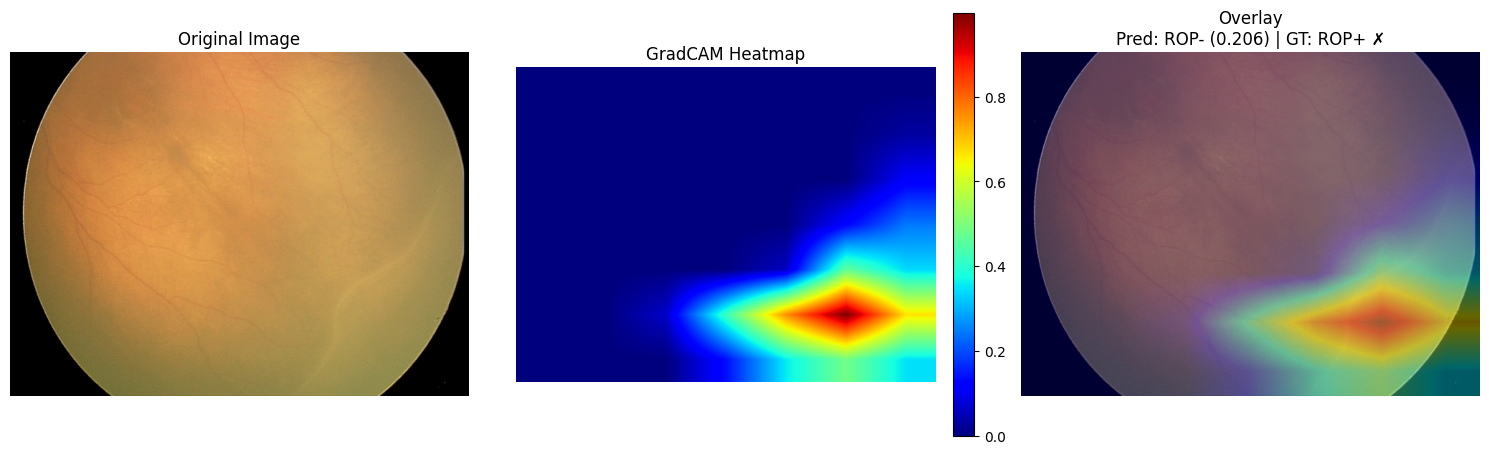


Image: 8.jpg


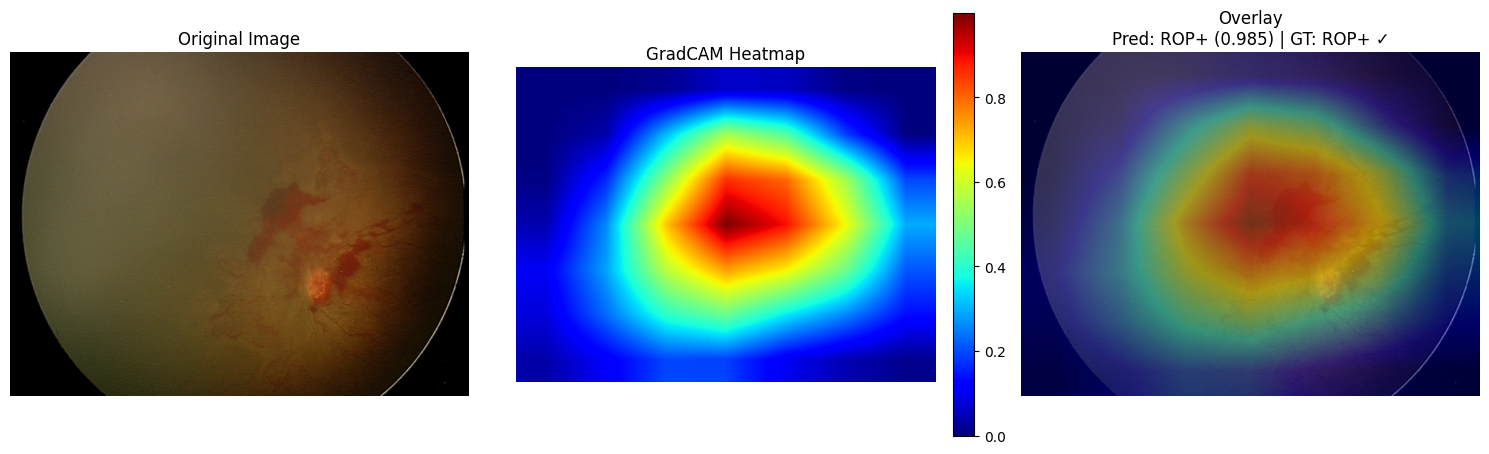

In [12]:
# Visualize ROP+ cases
print("=" * 60)
print("GradCAM for ROP POSITIVE cases")
print("=" * 60)
batch_visualize_gradcam(rop_positive, n_samples=3, alpha=0.4)

GradCAM for ROP NEGATIVE cases


C:\Users\HP\AppData\Local\Temp\ipykernel_13220\2946742073.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_loc


Image: 7.jpg


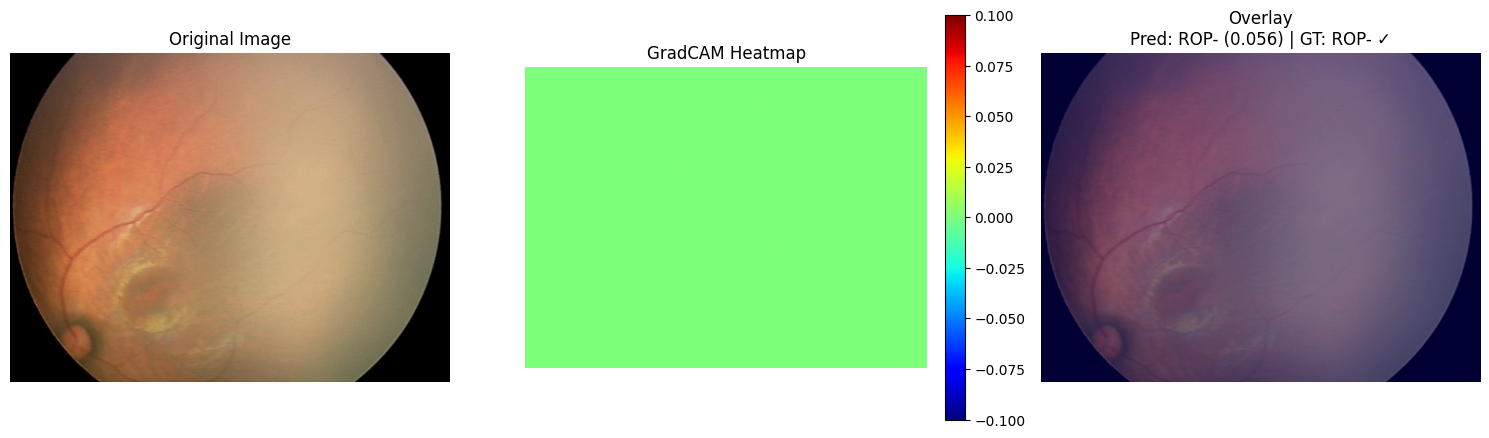


Image: 6.jpg


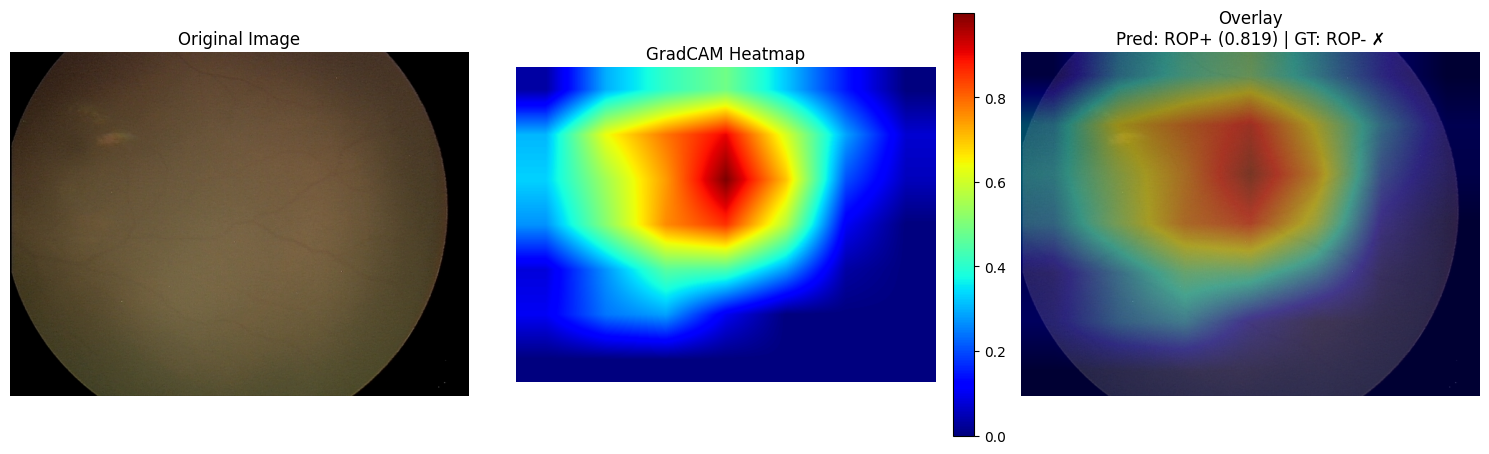


Image: 4.jpg


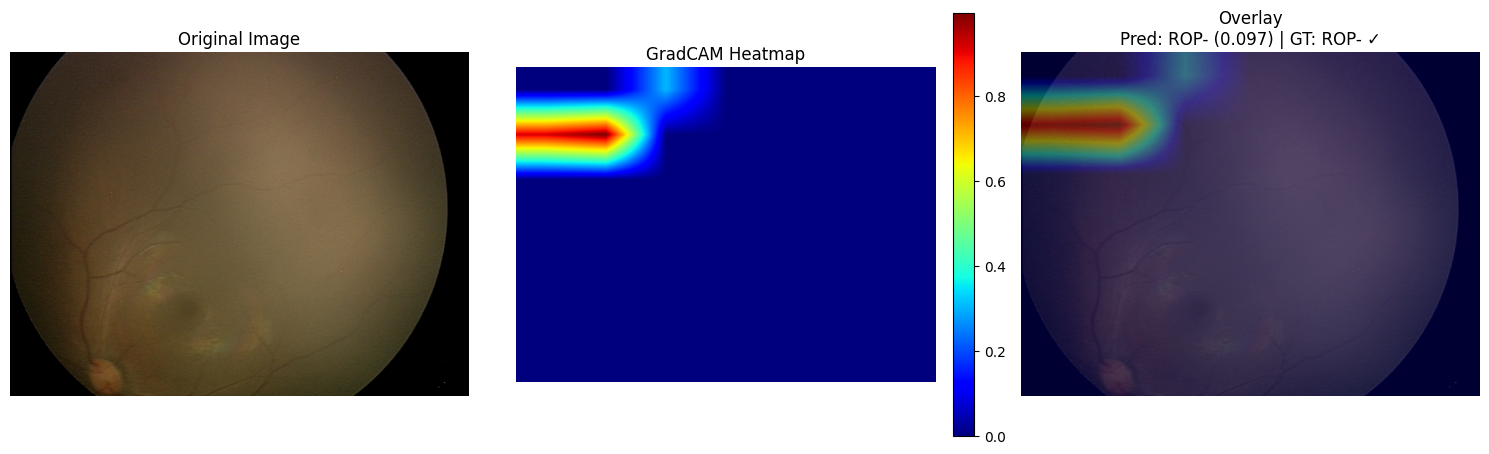

In [14]:
# Visualize ROP- cases
print("=" * 60)
print("GradCAM for ROP NEGATIVE cases")
print("=" * 60)
batch_visualize_gradcam(rop_negative, n_samples=3, alpha=0.4)

## 11. Experiment: Different Colormaps

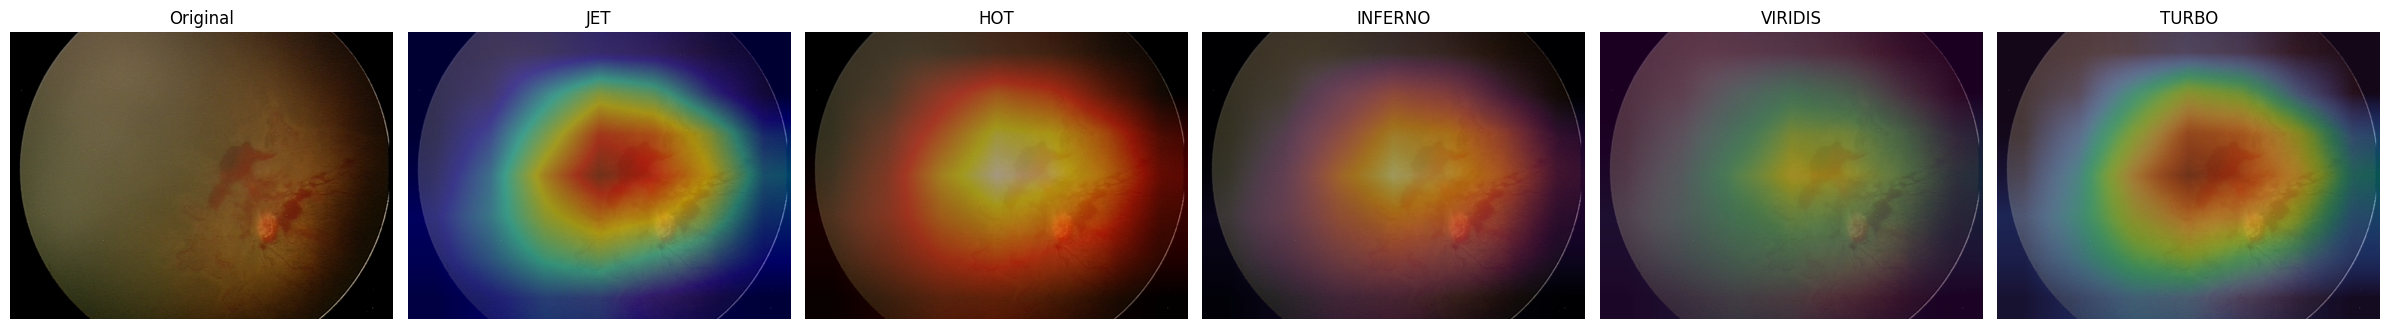

In [15]:
def visualize_colormaps(original_img, heatmap):
    """
    Visualize GradCAM with different OpenCV colormaps.
    """
    colormaps = [
        (cv2.COLORMAP_JET, 'JET'),
        (cv2.COLORMAP_HOT, 'HOT'),
        (cv2.COLORMAP_INFERNO, 'INFERNO'),
        (cv2.COLORMAP_VIRIDIS, 'VIRIDIS'),
        (cv2.COLORMAP_TURBO, 'TURBO'),
    ]
    
    fig, axes = plt.subplots(1, len(colormaps) + 1, figsize=(4 * (len(colormaps) + 1), 4))
    
    axes[0].imshow(original_img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    for i, (cmap, name) in enumerate(colormaps):
        overlay = overlay_heatmap(original_img, heatmap, alpha=0.4, colormap=cmap)
        axes[i + 1].imshow(overlay)
        axes[i + 1].set_title(name)
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize with different colormaps
visualize_colormaps(orig_img, heatmap)

## 12. Save GradCAM Results

In [16]:
def save_gradcam_results(df, output_dir, n_samples=None, alpha=0.4):
    """
    Save GradCAM overlay images to disk.
    
    Args:
        df: DataFrame with image paths and labels
        output_dir: Directory to save results
        n_samples: Number of samples (None for all)
        alpha: Overlay alpha value
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    
    # Reload model
    temp_model = ResNet18ROP(pretrained=False).to(DEVICE)
    temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
    temp_model.eval()
    
    gradcam = GradCAM(temp_model, temp_model.backbone.layer4)
    
    if n_samples:
        df = df.sample(n=min(n_samples, len(df)), random_state=42)
    
    saved_count = 0
    for idx, row in df.iterrows():
        img_path = row['Source']
        label = row['ROP Label']
        
        try:
            orig_img, heatmap, prediction = process_image(
                img_path, transform, temp_model, gradcam
            )
            
            overlay = overlay_heatmap(orig_img, heatmap, alpha)
            
            # Save with informative filename
            pred_str = 'pos' if prediction > 0.5 else 'neg'
            gt_str = 'pos' if label == 1 else 'neg'
            correct_str = 'correct' if (prediction > 0.5) == (label == 1) else 'wrong'
            
            filename = f"gradcam_gt{gt_str}_pred{pred_str}_{correct_str}_{idx}.png"
            out_path = output_dir / filename
            
            cv2.imwrite(str(out_path), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            saved_count += 1
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    print(f"\n✓ Saved {saved_count} GradCAM images to {output_dir}")
    del temp_model, gradcam

In [17]:
# Save GradCAM results for a sample of images
OUTPUT_DIR = PROJECT_ROOT / "gradcam_results" / "notebook_output"
save_gradcam_results(val_df, OUTPUT_DIR, n_samples=10, alpha=0.4)

C:\Users\HP\AppData\Local\Temp\ipykernel_13220\3782897063.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_loc


✓ Saved 10 GradCAM images to c:\Users\HP\Desktop\ROPDetectionAIML\gradcam_results\notebook_output


## 13. Interactive Image Selection

In [18]:
# Display available images for selection
print("Available images in validation set:")
print("\nROP+ images:")
for i, (idx, row) in enumerate(rop_positive.head(10).iterrows()):
    print(f"  [{i}] {Path(row['Source']).name}")

print("\nROP- images:")
for i, (idx, row) in enumerate(rop_negative.head(10).iterrows()):
    print(f"  [{i}] {Path(row['Source']).name}")

Available images in validation set:

ROP+ images:
  [0] 8.jpg
  [1] 7.jpg
  [2] 13.jpg
  [3] 4.jpg
  [4] 6.jpg
  [5] 11.jpg
  [6] 15.jpg
  [7] 5.jpg
  [8] 13.jpg
  [9] 6.jpg

ROP- images:
  [0] 4.jpg
  [1] 1.jpg
  [2] 4.jpg
  [3] 8.jpg
  [4] 3.jpg
  [5] 6.jpg
  [6] 8.jpg
  [7] 7.jpg
  [8] 2.jpg
  [9] 2.jpg


Processing: C:\Users\HP\Desktop\ROPDetectionAIML\data\images\2-4_25Nov\set 2\Input\6076V1\8.jpg


C:\Users\HP\AppData\Local\Temp\ipykernel_13220\2418472195.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_loc

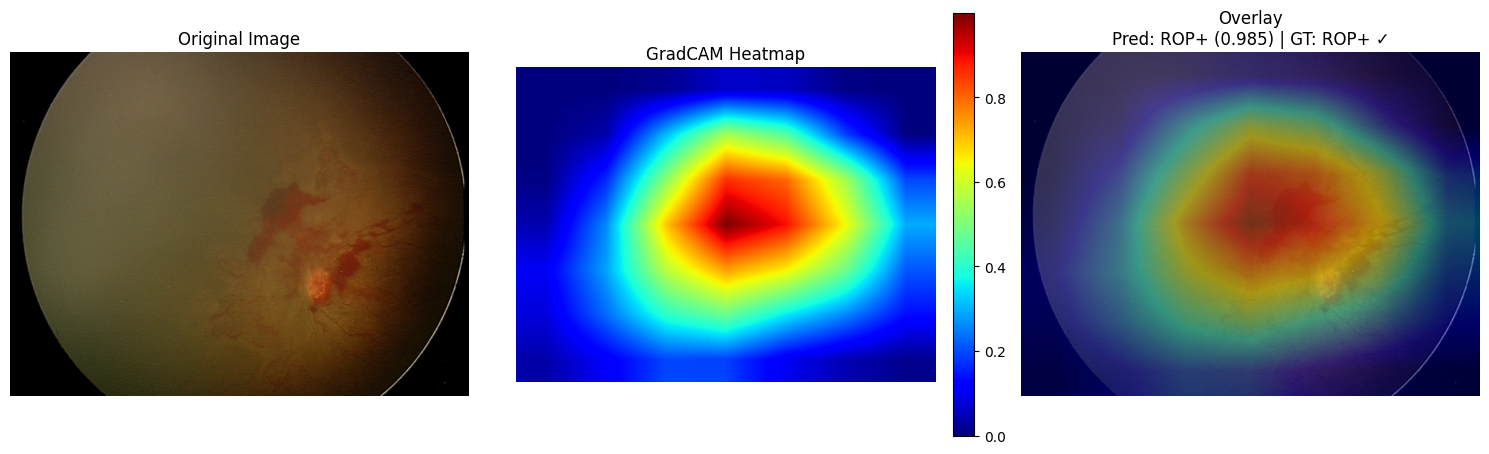

In [19]:
# Select and visualize a specific image by index
# Change these values to explore different images

SAMPLE_TYPE = 'positive'  # 'positive' or 'negative'
SAMPLE_INDEX = 0  # Index from the list above
ALPHA = 0.4  # Overlay transparency

# Get the selected image
if SAMPLE_TYPE == 'positive':
    selected_df = rop_positive
else:
    selected_df = rop_negative

if SAMPLE_INDEX < len(selected_df):
    selected_row = selected_df.iloc[SAMPLE_INDEX]
    selected_path = selected_row['Source']
    selected_label = selected_row['ROP Label']
    
    print(f"Processing: {selected_path}")
    
    # Reload model for clean hooks
    temp_model = ResNet18ROP(pretrained=False).to(DEVICE)
    temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
    temp_model.eval()
    temp_gradcam = GradCAM(temp_model, temp_model.backbone.layer4)
    
    orig_img, heatmap, prediction = process_image(
        selected_path, transform, temp_model, temp_gradcam
    )
    
    visualize_gradcam(orig_img, heatmap, prediction, selected_label, ALPHA)
    
    del temp_model, temp_gradcam
else:
    print(f"Index {SAMPLE_INDEX} out of range. Max index: {len(selected_df) - 1}")

## 14. Summary Statistics

In [20]:
def compute_gradcam_statistics(df, n_samples=50):
    """
    Compute statistics about GradCAM activations.
    """
    # Reload model
    temp_model = ResNet18ROP(pretrained=False).to(DEVICE)
    temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
    temp_model.eval()
    
    gradcam = GradCAM(temp_model, temp_model.backbone.layer4)
    
    sample_df = df.sample(n=min(n_samples, len(df)), random_state=42)
    
    results = []
    for idx, row in sample_df.iterrows():
        try:
            _, heatmap, prediction = process_image(
                row['Source'], transform, temp_model, gradcam
            )
            
            results.append({
                'label': row['ROP Label'],
                'prediction': prediction,
                'correct': (prediction > 0.5) == (row['ROP Label'] == 1),
                'heatmap_mean': heatmap.mean(),
                'heatmap_max': heatmap.max(),
                'heatmap_std': heatmap.std(),
                'high_activation_area': (heatmap > 0.5).mean(),  # % of high activation
            })
        except Exception as e:
            continue
    
    del temp_model, gradcam
    return pd.DataFrame(results)

# Compute statistics
print("Computing GradCAM statistics...")
stats_df = compute_gradcam_statistics(val_df, n_samples=30)
print(f"\nProcessed {len(stats_df)} images")

Computing GradCAM statistics...


C:\Users\HP\AppData\Local\Temp\ipykernel_13220\1994389439.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_loca


Processed 30 images


In [21]:
# Display statistics
print("\n" + "="*60)
print("GradCAM Statistics by Label")
print("="*60)

for label in [0, 1]:
    label_data = stats_df[stats_df['label'] == label]
    label_name = "ROP+" if label == 1 else "ROP-"
    
    print(f"\n{label_name} samples (n={len(label_data)}):")
    print(f"  Accuracy: {label_data['correct'].mean():.2%}")
    print(f"  Mean prediction: {label_data['prediction'].mean():.3f}")
    print(f"  Mean heatmap activation: {label_data['heatmap_mean'].mean():.3f}")
    print(f"  High activation area (>0.5): {label_data['high_activation_area'].mean():.2%}")


GradCAM Statistics by Label

ROP- samples (n=22):
  Accuracy: 77.27%
  Mean prediction: 0.265
  Mean heatmap activation: 0.116
  High activation area (>0.5): 10.20%

ROP+ samples (n=8):
  Accuracy: 75.00%
  Mean prediction: 0.719
  Mean heatmap activation: 0.207
  High activation area (>0.5): 15.82%


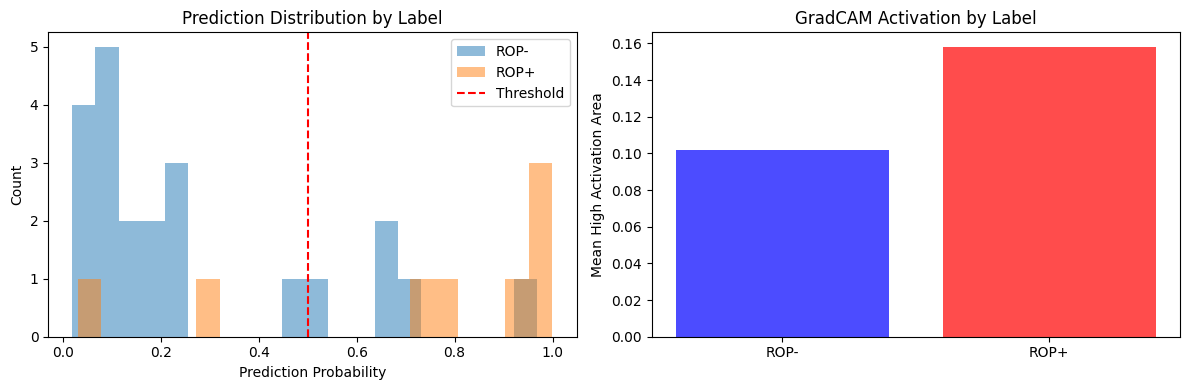

In [22]:
# Visualize statistics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Prediction distribution by label
for label in [0, 1]:
    label_data = stats_df[stats_df['label'] == label]
    label_name = "ROP+" if label == 1 else "ROP-"
    axes[0].hist(label_data['prediction'], bins=20, alpha=0.5, label=label_name)

axes[0].axvline(x=0.5, color='red', linestyle='--', label='Threshold')
axes[0].set_xlabel('Prediction Probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Prediction Distribution by Label')
axes[0].legend()

# High activation area by label
labels = ['ROP-', 'ROP+']
high_act = [stats_df[stats_df['label'] == l]['high_activation_area'].mean() for l in [0, 1]]
axes[1].bar(labels, high_act, color=['blue', 'red'], alpha=0.7)
axes[1].set_ylabel('Mean High Activation Area')
axes[1].set_title('GradCAM Activation by Label')

plt.tight_layout()
plt.show()

## 15. Custom Image Testing

Use this section to test GradCAM on any custom image path.

In [23]:
# Set custom image path here
CUSTOM_IMAGE_PATH = None  # Set to a valid image path to test

# Example:
# CUSTOM_IMAGE_PATH = r"C:\Users\HP\Desktop\ROPDetectionAIML\data\images\2-4_25Nov\set 2\Input\6060V2\11.jpg"

if CUSTOM_IMAGE_PATH and Path(CUSTOM_IMAGE_PATH).exists():
    print(f"Processing custom image: {CUSTOM_IMAGE_PATH}")
    
    # Reload model
    temp_model = ResNet18ROP(pretrained=False).to(DEVICE)
    temp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
    temp_model.eval()
    temp_gradcam = GradCAM(temp_model, temp_model.backbone.layer4)
    
    orig_img, heatmap, prediction = process_image(
        CUSTOM_IMAGE_PATH, transform, temp_model, temp_gradcam
    )
    
    print(f"\nPrediction: {prediction:.4f} ({'ROP+' if prediction > 0.5 else 'ROP-'})")
    
    # Full visualization
    visualize_gradcam(orig_img, heatmap, prediction, label=-1, alpha=0.4)
    visualize_multiple_alphas(orig_img, heatmap)
    visualize_colormaps(orig_img, heatmap)
    
    del temp_model, temp_gradcam
else:
    print("Set CUSTOM_IMAGE_PATH to a valid image path to test.")
    print("Example paths from validation set:")
    for i, path in enumerate(val_df['Source'].head(3)):
        print(f"  {path}")

Set CUSTOM_IMAGE_PATH to a valid image path to test.
Example paths from validation set:
  C:\Users\HP\Desktop\ROPDetectionAIML\data\images\2-4_25Nov\set 4\Input\3985V2\4.jpg
  C:\Users\HP\Desktop\ROPDetectionAIML\data\images\2-4_25Nov\set 4\Input\3970V4\1.jpg
  C:\Users\HP\Desktop\ROPDetectionAIML\data\images\2-4_25Nov\set 2\Input\6017V1\4.jpg
